### Exercice 1

In [20]:
# Imports General
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time
import matplotlib

In [21]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler


In [22]:
import csv
import math
import scipy.ndimage as nd
from scipy.stats.mstats import mquantiles, kurtosis, skew
from sklearn.preprocessing import LabelEncoder


In [23]:
# Import OpenCV
import cv2


In [6]:
train_path='images/'
valid_path='images/'


In [9]:
# Let's read each image filename in out list and store the corresponding image 
# Name to each class as X_train. Also, store the labels of galaxies as 1  and 0.
#
csvFile = open("GTI770_label_data_set.csv", "r")
count = 0

Y = np.ones(10000 , dtype=str)
X = [''] * 10000
choices = {'spiral' : 1, 'smooth': 0}
tic = time.time()
for i in csvFile:
    id_, name = i.split(',')
    if id_ != "id":
        imagePath = train_path + id_ + '.jpg'
        if not os.path.exists(imagePath):
            continue
        #print('imagePath exists', count)
        X[count] = id_ + '.jpg'
        Y[count]=  choices.get(name.rstrip(), 99)
        count += 1
        if count == 10000:
            break
print('Completed in', (time.time() - tic))

Completed in 0.1975257396697998


In [10]:
#La matrice X a été divisée en 2 matrices avec un ratio de 70% (X_train)
#et 30% (X_test). Aussi, la matrice Y a été divisée en deux matrices de Y_train et Y_test.

from sklearn.model_selection import train_test_split
X_train, X_test1, Y_train, Y_test1 = train_test_split(X, Y, test_size=0.4,stratify=Y)

In [ ]:
X_test, X_validation, Y_test, Y_validation = train_test_split(X_test1, Y_test1, test_size=0.5,stratify=Y_test1) 

In [11]:
''' Create empty feature vectors to store the features that we will extract from images
feature #1: Maximum values of Red and Blue channels for cropped image of 64 x 64
feature #2: Red to Blue color intensity ratio for cropped image of 64 x 64
feature #3: Black to White pixel ratio for cropped image of 64 x 64

In the feature_vector, the first two columns are maximum red and maximum blue color
and in the third column, 
'''
num_features = 6

# If we want to add the label at the end of the feature vector, we must add a dimension
num_features = num_features + 1
# This array lives on the GPU since we passed the gpu_device context
feature_vector_train = np.zeros( (len(X_train), num_features))
feature_vector_test = np.zeros( (len(X_test), num_features))


In [24]:
img_count = 0

# Loop for each image in the list
for file_name in X_train:
    # Read the image
    img_color = cv2.imread(train_path+file_name,-1)
        # Create a gray scale of image
    img_grey=cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)  
    ret,img_binary = cv2.threshold(img_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # create a matrix to store color RGB pixels of each image
    colorMatrix=np.ones((4096,2),dtype=int)
        # Initialize variables with zero 
    n_white_pix=0
    n_black_pix=0
    index=0
    print ("Processing image " +str(img_count+1)+" "+file_name ) 
        
    # Feature 1 start #############################################################
    # Loop that reads each image pixel
    # =============================================================================
    #     for i in range(187,237):
    #         for j in range(187,237):
    # =============================================================================
    for i in range(180,244):
          for j in range(180,244):     
                red = img_color[i][j][2]
                gre = img_color[i][j][1]
                blu = img_color[i][j][0]
                colorMatrix[index,0]=red
                colorMatrix[index,1]=blu
                index+=1              
                if img_binary[i,j]==255:
                    n_white_pix+=1
                else:
                    n_black_pix+=1
    # Store the features values in the columns of the feature (matrix) vector
    # feature 1, 2, 3 and 4
    redColumnAverage=np.mean(colorMatrix[:,0]) #mean of red colmun
    blueColumnAverage=np.mean(colorMatrix[:,1]) #mean of blue colmun   
    red2blueRatio=redColumnAverage/blueColumnAverage  # ratio of red to blue for each image          
    black2whitePixelRatio=n_black_pix/n_white_pix # ratio of black pixel number to white pixel number
    
    # Feature Morphology ###################################
    img_blurred=cv2.pyrMeanShiftFiltering(img_color,61,181)
    
    img_grey=cv2.cvtColor(img_blurred,cv2.COLOR_BGR2GRAY)
    ret,img_binary_grey = cv2.threshold(img_grey,245,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _,contours,_=cv2.findContours(img_binary_grey,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(img_color,contours,-1,(130,255,255),3)
        
    ## find best contour for image
    best_contour_ma = 0
    best_contour_MA = 0

    for i, contour in enumerate(contours):
        try: 
            (x,y),(MA,ma),angle=cv2.fitEllipse(contour)
        
            print("Contour", i)

            if (MA * ma > best_contour_ma * best_contour_MA):
                best_contour_ma = ma
                best_contour_MA = MA
        except:
            print('Couldn\'t fit ellipse from contour');
            
    if best_contour_ma == 0 or best_contour_MA == 0:
        maByMa = -1
        print('Tried all contours and none of them could fit ellipse')
    else:
        maByMA = best_contour_ma/best_contour_MA

    feature_vector_train[img_count] = [np.max(colorMatrix[:,0]), np.max(colorMatrix[:,1]),red2blueRatio,black2whitePixelRatio, maByMA, angle, Y_train[img_count]]
  
    img_count += 1
    
    # Save the extracted feature vector into a text file.
    np.savetxt("feature_vector_train.csv", feature_vector_train, delimiter=",")
        
print("Feature extraction ended successfully")

Processing image 1 218281.jpg
Couldn't fit ellipse from contour
Contour 1
Processing image 2 158512.jpg
Contour 0
Processing image 3 183259.jpg
Contour 0
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Contour 3
Contour 4
Processing image 4 142257.jpg
Couldn't fit ellipse from contour
Contour 1
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Contour 5
Processing image 5 523496.jpg
Couldn't fit ellipse from contour
Contour 1
Processing image 6 319333.jpg
Contour 0
Processing image 7 128799.jpg
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Contour 3
Couldn't fit ellipse from contour
Contour 5
Contour 6
Contour 7
Processing image 8 136929.jpg
Couldn't fit ellipse from contour
Contour 1
Contour 2
Processing image 9 417028.jpg
Contour 0
Processing image 10 458062.jpg
Contour 0
Contour 1
Contour 2
Contour 3
Contour 4
Contour 5
Processing image 11 346053.jpg
Contou

In [25]:
## Same thing, but for test data
img_count = 0

# Loop for each image in the list
for file_name in X_test:
    # Read the image
    img_color = cv2.imread(train_path+file_name,-1)
        # Create a gray scale of image
    img_grey=cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)  
    ret,img_binary = cv2.threshold(img_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # create a matrix to store color RGB pixels of each image
    colorMatrix=np.ones((4096,2),dtype=int)
        # Initialize variables with zero 
    n_white_pix=0
    n_black_pix=0
    index=0
    print ("Processing image " +str(img_count+1)+" "+file_name ) 

    for i in range(180,244):
          for j in range(180,244):     
                red = img_color[i][j][2]
                gre = img_color[i][j][1]
                blu = img_color[i][j][0]
                colorMatrix[index,0]=red
                colorMatrix[index,1]=blu
                index+=1              
                if img_binary[i,j]==255:
                    n_white_pix+=1
                else:
                    n_black_pix+=1
    # Store the features values in the columns of the feature (matrix) vector
    # feature 1, 2, 3 and 4
    redColumnAverage=np.mean(colorMatrix[:,0]) #mean of red colmun
    blueColumnAverage=np.mean(colorMatrix[:,1]) #mean of blue colmun   
    red2blueRatio=redColumnAverage/blueColumnAverage  # ratio of red to blue for each image          
    black2whitePixelRatio=n_black_pix/n_white_pix # ratio of black pixel number to white pixel number
    
    # Feature Morphology ###################################
    img_blurred=cv2.pyrMeanShiftFiltering(img_color,61,181)
    
    img_grey=cv2.cvtColor(img_blurred,cv2.COLOR_BGR2GRAY)
    ret,img_binary_grey = cv2.threshold(img_grey,245,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _,contours,_=cv2.findContours(img_binary_grey,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(img_color,contours,-1,(130,255,255),3)
        
    ## find best contour for image
    best_contour_ma = 0
    best_contour_MA = 0

    for i, contour in enumerate(contours):
        try: 
            (x,y),(MA,ma),angle=cv2.fitEllipse(contour)
        
            print("Contour", i)

            if (MA * ma > best_contour_ma * best_contour_MA):
                best_contour_ma = ma
                best_contour_MA = MA
        except:
            print('Couldn\'t fit ellipse from contour');
            
    if best_contour_ma == 0 or best_contour_MA == 0:
        maByMa = -1
        print('Tried all contours and none of them could fit ellipse')
    else:
        maByMA = best_contour_ma/best_contour_MA

    feature_vector_test[img_count] = [np.max(colorMatrix[:,0]), np.max(colorMatrix[:,1]),red2blueRatio,black2whitePixelRatio, maByMA, angle, Y_test[img_count]]
  
    img_count += 1
    
    # Save the extracted feature vector into a text file.
    np.savetxt("feature_vector_test.csv", feature_vector_test, delimiter=",")
        
print("Feature extraction ended successfully")

Processing image 1 559937.jpg
Contour 0
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Contour 4
Couldn't fit ellipse from contour
Contour 6
Contour 7
Couldn't fit ellipse from contour
Processing image 2 132754.jpg
Couldn't fit ellipse from contour
Contour 1
Contour 2
Processing image 3 345199.jpg
Contour 0
Processing image 4 176207.jpg
Contour 0
Contour 1
Contour 2
Processing image 5 609318.jpg
Contour 0
Contour 1
Contour 2
Processing image 6 281121.jpg
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Contour 2
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Contour 6
Contour 7
Contour 8
Processing image 7 631021.jpg
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Contour 2
Contour 3
Contour 4
Processing image 8 184703.jpg
Contour 0
Contour 1
Processing image 9 141605.jpg
Contour 0
Contour 1
Processing image 10 606098.jpg
Contour 0
Process

In [ ]:
## Same thing, but for Validation data
img_count = 0

# Loop for each image in the list
for file_name in X_validation:
    # Read the image
    img_color = cv2.imread(train_path+file_name,-1)
        # Create a gray scale of image
    img_grey=cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)  
    ret,img_binary = cv2.threshold(img_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # create a matrix to store color RGB pixels of each image
    colorMatrix=np.ones((4096,2),dtype=int)
        # Initialize variables with zero 
    n_white_pix=0
    n_black_pix=0
    index=0
    print ("Processing image " +str(img_count+1)+" "+file_name ) 

    for i in range(180,244):
          for j in range(180,244):     
                red = img_color[i][j][2]
                gre = img_color[i][j][1]
                blu = img_color[i][j][0]
                colorMatrix[index,0]=red
                colorMatrix[index,1]=blu
                index+=1              
                if img_binary[i,j]==255:
                    n_white_pix+=1
                else:
                    n_black_pix+=1
    # Store the features values in the columns of the feature (matrix) vector
    # feature 1, 2, 3 and 4
    redColumnAverage=np.mean(colorMatrix[:,0]) #mean of red colmun
    blueColumnAverage=np.mean(colorMatrix[:,1]) #mean of blue colmun   
    red2blueRatio=redColumnAverage/blueColumnAverage  # ratio of red to blue for each image          
    black2whitePixelRatio=n_black_pix/n_white_pix # ratio of black pixel number to white pixel number
    
    # Feature Morphology ###################################
    img_blurred=cv2.pyrMeanShiftFiltering(img_color,61,181)
    
    img_grey=cv2.cvtColor(img_blurred,cv2.COLOR_BGR2GRAY)
    ret,img_binary_grey = cv2.threshold(img_grey,245,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _,contours,_=cv2.findContours(img_binary_grey,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(img_color,contours,-1,(130,255,255),3)
        
    ## find best contour for image
    best_contour_ma = 0
    best_contour_MA = 0

    for i, contour in enumerate(contours):
        try: 
            (x,y),(MA,ma),angle=cv2.fitEllipse(contour)
        
            print("Contour", i)

            if (MA * ma > best_contour_ma * best_contour_MA):
                best_contour_ma = ma
                best_contour_MA = MA
        except:
            print('Couldn\'t fit ellipse from contour');
            
    if best_contour_ma == 0 or best_contour_MA == 0:
        maByMa = -1
        print('Tried all contours and none of them could fit ellipse')
    else:
        maByMA = best_contour_ma/best_contour_MA

    feature_vector_test[img_count] = [np.max(colorMatrix[:,0]), np.max(colorMatrix[:,1]),red2blueRatio,black2whitePixelRatio, maByMA, angle, Y_validation[img_count]]
  
    img_count += 1
    
    # Save the extracted feature vector into a text file.
    np.savetxt("feature_vector_validation.csv", feature_vector_test, delimiter=",")
        
print("Feature extraction ended successfully")

C:\Users\RyanM\Anaconda3\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "l". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


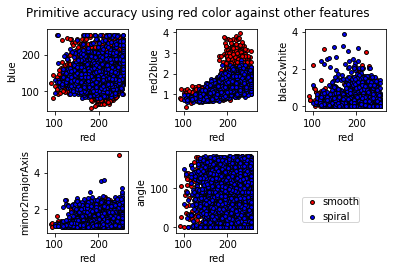

In [15]:
# Parameters
n_classes = 2
plot_colors = "rb"
plot_step = 0.02
feature_names=['red','blue','red2blue','black2white','minor2majorAxis','angle']
# Load data
iris =np.loadtxt("feature_vector_train.csv", delimiter=",")
target_names=["smooth", "spiral"]
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], 
                                [0, 4], [0, 5]]):
    # We only take the two corresponding features
    X = iris[:, pair]
    y = iris[:,6]

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)
   # f, axs = plt.subplots(2,3,pairidx + 1,figsize=(10,10))
    
    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
        plt.xlabel(feature_names[pair[0]])
        plt.ylabel(feature_names[pair[1]])
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
       

plt.suptitle("Primitive accuracy using red color against other features")
plt.legend(loc="l", bbox_to_anchor=(1.5,0.5), borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

C:\Users\RyanM\Anaconda3\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "l". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


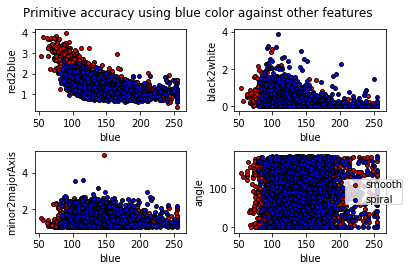

In [16]:

for pairidx, pair in enumerate([[1, 2], [1, 3], [1, 4], [1, 5]]):
    
    # We only take the two corresponding features
    X = iris[:, pair]
    y = iris[:,6]

    # Plot the decision boundary
    plt.subplot(2, 2, pairidx + 1)
   # f, axs = plt.subplots(2,3,pairidx + 1,figsize=(10,10))
    
    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
        plt.xlabel(feature_names[pair[0]])
        plt.ylabel(feature_names[pair[1]])
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
       

plt.suptitle("Primitive accuracy using blue color against other features")
plt.legend(loc="l", bbox_to_anchor=(0.7,0.5), borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

C:\Users\RyanM\Anaconda3\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "l". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


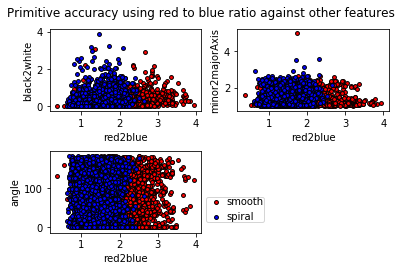

In [17]:
for pairidx, pair in enumerate([
                                [2, 3], [2, 4], [2, 5]]):
    # We only take the two corresponding features
    X = iris[:, pair]
    y = iris[:,6]

    # Plot the decision boundary
    plt.subplot(2, 2, pairidx + 1)
   # f, axs = plt.subplots(2,3,pairidx + 1,figsize=(10,10))
    
    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
        plt.xlabel(feature_names[pair[0]])
        plt.ylabel(feature_names[pair[1]])
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
       

plt.suptitle("Primitive accuracy using red to blue ratio against other features")
plt.legend(loc="l", bbox_to_anchor=(1,0.5), borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

C:\Users\RyanM\Anaconda3\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "l". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


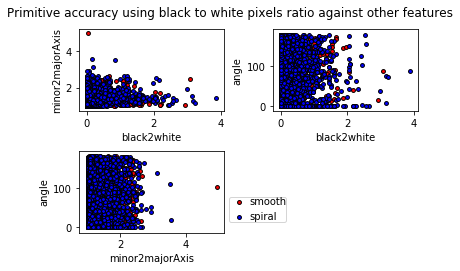

In [18]:
for pairidx, pair in enumerate([
                                [3, 4], [3, 5],
                                [4, 5]]):
    # We only take the two corresponding features
    X = iris[:, pair]
    y = iris[:,6]

    # Plot the decision boundary
    plt.subplot(2, 2, pairidx + 1)
   # f, axs = plt.subplots(2,3,pairidx + 1,figsize=(10,10))
    
    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
        plt.xlabel(feature_names[pair[0]])
        plt.ylabel(feature_names[pair[1]])
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
       

plt.suptitle("Primitive accuracy using black to white pixels ratio against other features")
plt.legend(loc="l", bbox_to_anchor=(1,0.5), borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

In [12]:
# to visualize the tree you must install this library
# conda install python-graphviz OR pip install graphviz
import graphviz
from sklearn import tree

In [13]:
# Load data from file
# File with 4 features extracted from galaxies
num_features = 6
data_train = np.loadtxt("feature_vector_test.csv", delimiter=",")

In [14]:
# Define the training set
# Just for two classes (Smooth=0 and Spiral =1)

X_train  = data_train[:,0:num_features]
Y_train  = data_train[:,num_features]

In [15]:
# Train the Decision Tree with the training set
model = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10)
model = model.fit(X_train, Y_train)

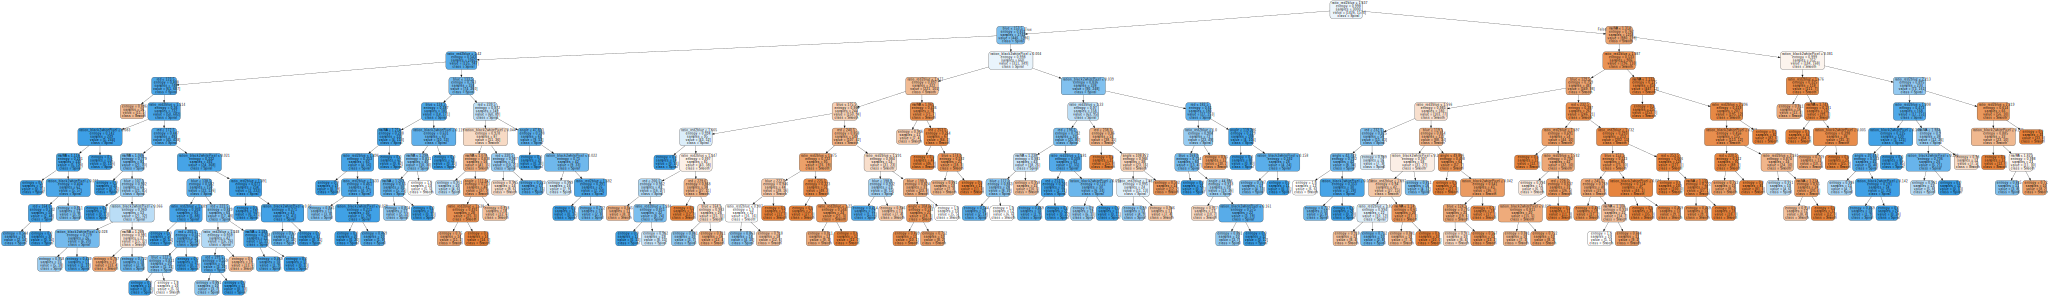

In [16]:
feature_names = ['red', 'blue', 'ratio_red2blue', 'ration_black2whitePixel', 'ma/MA', 'angle']

dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=feature_names,
                         class_names = ['Smooth', 'Spiral'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render("SpiralGalaxy_Data", view=True) 
graph 

In [17]:
# predict the class of samples
# train dataset
Y_train_pred = model.predict(X_train)
Y_train_pred

array([1., 0., 0., ..., 0., 1., 1.])

In [18]:
# predict the probability of each class
# train dataset

Y_train_pred_prob = model.predict_proba(X_train)
Y_train_pred_prob

array([[0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       ...,
       [0.72727273, 0.27272727],
       [0.11764706, 0.88235294],
       [0.        , 1.        ]])

In [19]:
# evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [20]:
acc_galaxy_train = accuracy_score(Y_train, Y_train_pred )
print("Correct classification rate for train dataset = "+str(acc_galaxy_train*100)+"%")

Correct classification rate for train dataset = 90.9%


In [21]:
from sklearn.metrics import classification_report

In [22]:
target_names = ['Smooth', 'Spiral']
print( classification_report(Y_train, Y_train_pred, target_names=target_names))

cm_galaxy_train = confusion_matrix(Y_train, Y_train_pred )
cm_galaxy_train

             precision    recall  f1-score   support

     Smooth       0.89      0.92      0.91      1426
     Spiral       0.93      0.90      0.91      1574

avg / total       0.91      0.91      0.91      3000



array([[1315,  111],
       [ 162, 1412]])

In [23]:
import itertools
import numpy as np
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [24]:
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[1315  111]
 [ 162 1412]]


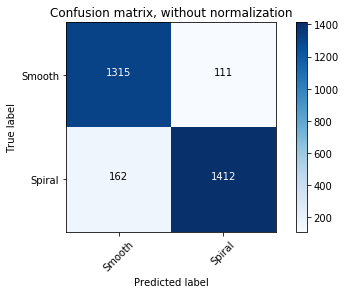

In [25]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_galaxy_train, classes= ['Smooth', 'Spiral'],
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.92 0.08]
 [0.1  0.9 ]]


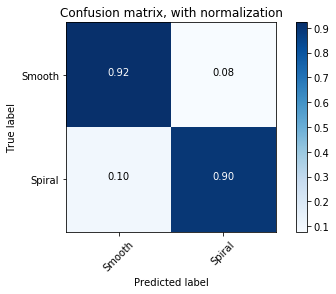

In [26]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_galaxy_train, classes= ['Smooth', 'Spiral'], normalize=True,
                      title='Confusion matrix, with normalization')


plt.show()


In [ ]:
from itertools import product

# Parameters
n_classes = 2
plot_colors = "rb"
plot_step = 0.02

print(data_train)
print(data_train[:, [0, 1]])
print(data_train[:, [0, 1]][:, 0])
print(data_train[:, [0, 1]][:, 1])

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [0, 4], [0, 5],
                                [1, 2], [1, 3], [1, 4], [1, 5],
                                [2, 3], [2, 4], [2, 5],
                                [3, 4], [3, 5],
                                [4, 5]]):
    print(pair)
    # We only take the two corresponding features
    X = data_train[:, pair]
    y = data_train[:, [6]]

    # Train
    clf = tree.DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(3, 5, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(feature_names[pair[0]])
    plt.ylabel(feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

[[241.   138.     1.46 ...   1.22   0.     1.  ]
 [230.   118.     2.57 ...   1.11  90.81   0.  ]
 [225.   142.     1.56 ...   1.32 109.62   0.  ]
 ...
 [178.   174.     1.01 ...   1.25 105.21   0.  ]
 [238.   142.     1.45 ...   1.36 122.4    1.  ]
 [198.   128.     1.27 ...   1.05  19.35   1.  ]]
[[241. 138.]
 [230. 118.]
 [225. 142.]
 ...
 [178. 174.]
 [238. 142.]
 [198. 128.]]
[241. 230. 225. ... 178. 238. 198.]
[138. 118. 142. ... 174. 142. 128.]
[0, 1]
